<a href="https://colab.research.google.com/github/abolghasem28/Safe-path-planning/blob/main/Copy_of_tut2_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install dependencies
!pip install casadi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 MB 8.3 MB/s eta 0:00:00


# Safe Autonomy Tutorial: Motion Planning

In this tutorial, you will get familiar with different optimization-based motion planning techniques to obtain a collision-free trajectory for a dynamical system. We will reuse parts from the 0th tutorial, so you should be familiar the optimization problem formulation. The overall assignment is seperated into three parts:

1.   E-Level: Optimization-based motion planning Intro
2.   C-Level: Optimization-based motion planning in dynamic environments + Feedback motion primitive generation
3.   A-Level: A*-based motion planning with feedback motion primitives



In [ ]:
import numpy as np
from math import *

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from copy import deepcopy, copy

## Optimization-based Motion Planning: Static Obstacles

The goal of this section is to find a dynamically feasible trajectory from an initial state to a goal state while optimizing a performance measure subject to obstacle avoidance constraints. The standard formulation of an optimization (or optimal control) problem can be formulated as

$$
\begin{aligned}
	\min_{\mathbf{u}_{1:N-1}, \mathbf{x}_{1:N}} \quad &\sum_{t=1}^{N} J(\mathbf{x}_t, \mathbf{u}_t)\\
	\textrm{s.t.  } \quad  &\mathbf{x}_{t+1} = \mathbf{f}\left(\mathbf{x}_t, \mathbf{u}_t\right) \hspace{0.5cm} &&\forall t = 1, \cdots, N-1\\
  &\mathbf{x}_{t}  \notin \mathcal{X}_{obs} \hspace{0.5cm} &&\forall t = 1, \cdots, N\\
  & \mathbf{u}_t \in \mathcal{U} &&\forall t = 1, \cdots, N-1\\
	& \mathbf{x}_N \in \mathcal{X}_g, \mathbf{x}_0 = \mathbf{x}(t_0)
    \end{aligned}.
$$
where $J$ is the stage cost and $\mathcal{X}_{obs}$ is the set of obstacle positions.

First, we define the environment in which our robot (drone from 0th tutorial) is operating. This 2d environment consists of a number of polygon obstacle regions. A single convex polygon is given as a list of points.

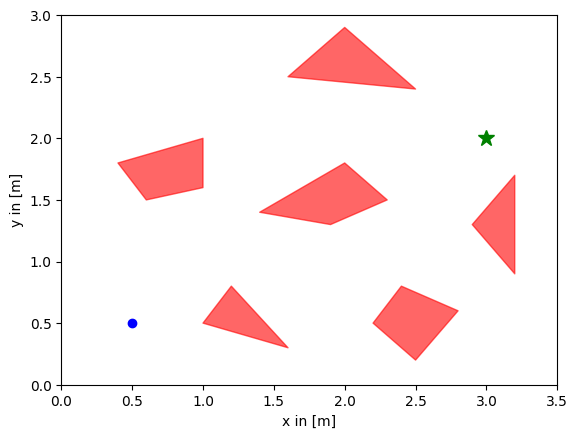

In [ ]:
# Initial state of the robot
x0 = [0.5, 0.5, 0.]

# Goal state
xG = [3., 2., 0.]

# For collision checking we will overapproximate the robot with a circle of radius r
r = 0.15

# Define obstacles in the environment (Each obstacle is defined by a list of its vertex positions)
obstacles = []
obstacles.append([[1., 0.5], [1.2, 0.8], [1.6, 0.3]])
obstacles.append([[0.6, 1.5], [0.4, 1.8], [1., 2.], [1., 1.6]])
obstacles.append([[1.4, 1.4], [2., 1.8], [2.3, 1.5], [1.9, 1.3]])
obstacles.append([[2.9, 1.3], [3.2, 1.7], [3.2, 0.9]])
obstacles.append([[2.5, 0.2], [2.2, 0.5], [2.4, 0.8], [2.8, 0.6]])
obstacles.append([[1.6, 2.5], [2., 2.9], [2.5, 2.4]])


# Plot environment
fig, ax = plt.subplots()

patches = []
for obs in obstacles:
    p = Polygon(obs)
    patches.append(p)


p_col = PatchCollection(patches, alpha=0.6)
p_col.set_color([1, 0, 0])
ax.add_collection(deepcopy(p_col))
ax.plot([x0[0]], [x0[1]], marker='o', color="b")
ax.plot([xG[0]], [xG[1]], marker='*', color="g", markersize=12)
ax.set_xlim([0,3.5])
ax.set_ylim([0,3])
ax.set_xlabel("x in [m]")
ax.set_ylabel("y in [m]")
plt.show()


Typically, we distinguish between different optimization techniques such as gradient-based or sampling-based optimization. There are lots of different reasons why one approach is more suitable than the other one which depends heavily on the problem setting. In the following, we will focus on **gradient-based approaches in which it is crucial to have smooth cost functions and constraints. If cost or constraint functions are nonsmooth, gradient-based approaches may fail as the gradient does not exist at discontinuities.** In case you want to learn more about numerical optimization in general, I can recommend $\href{https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf}{this}$ (Convex Optimization) and $ \href{https://algorithmsbook.com/optimization/files/optimization.pdf}{this}$ (Algorithms for Optimization) book.


Ideally, to set up the optimization problem, we would like to say something like "distance between robot and polygons greater than XX". However, the distance function between a polygon and a point has a nonsmooth gradient which will complicate standart optimization techniques. Therefore, we will introduce a commonly used smooth approximation: Minimum Volume Enclosing Ellipsoids (MVEE). An ellipsoid can be described by

\begin{align}
\mathcal{E} = \left\{ \mathbf{x} \in \mathbb{R}^n \mid \left(\mathbf{x} - \mathbf{c}\right)^T \mathbf{A} \left(\mathbf{x} - \mathbf{c}\right) \leq 1\right\}
\end{align}
where $\mathbf{A} \in \mathbb{R}^{n \times n}$ and $\mathbf{c} \in \mathbb{R}^n$ is the center of the ellipsoid. There are a lot of different approaches to obtain the minimmum ellipse that contains a given polygon $\mathcal{P}$. One of these approaches is implemented in the following, if you would like to read up on that, I would recommend Chapter 8.4.1 of "Convex Optimization".



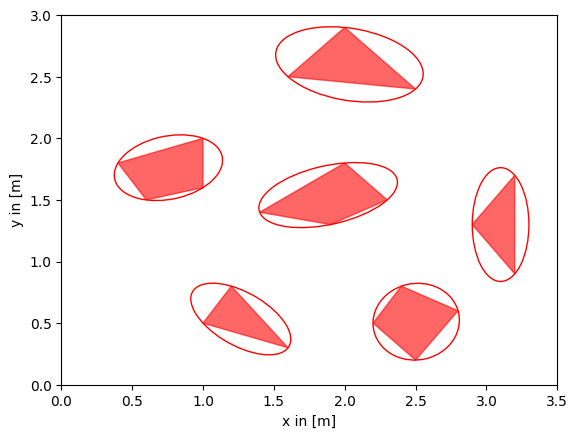

In [ ]:
from matplotlib.patches import Ellipse

# MVEE algorithm
def mvee(points, tol=0.0001):
    """
    Finds the ellipse equation in "center form"
    (x-c).T * A * (x-c) = 1
    """
    N, d = points.shape
    Q = np.column_stack((points, np.ones(N))).T
    err = tol+1.0
    u = np.ones(N)/N
    while err > tol:
        X = np.dot(np.dot(Q, np.diag(u)), Q.T)
        M = np.diag(np.dot(np.dot(Q.T, np.linalg.inv(X)), Q))
        jdx = np.argmax(M)
        step_size = (M[jdx]-d-1.0)/((d+1)*(M[jdx]-1.0))
        new_u = (1-step_size)*u
        new_u[jdx] += step_size
        err = np.linalg.norm(new_u-u)
        u = new_u
    c = np.dot(u, points)
    A = np.linalg.inv(np.dot(np.dot(points.T, np.diag(u)), points)
               - np.multiply.outer(c, c))/d
    return A, c

# initialize list of ellipsoids [(A_1, c_1), ...]
obstacle_ellipsoids = []

for obs in obstacles:
    A, c = mvee(np.array(obs))
    obstacle_ellipsoids.append((A, c))


# Visualize environment
fig, ax = plt.subplots()

ax.add_collection(deepcopy(p_col))

ellipses = []
for (A, c) in obstacle_ellipsoids:
    # Eigendecomposition of A
    Lambda, R = np.linalg.eig(A)
    width = 2 * sqrt(1 / Lambda[0])
    height = 2 * sqrt(1 / Lambda[1])
    angle = atan2(R[1, 0], R[0, 0]) * 180 / pi
    ellipse = Ellipse(c, width, height, angle=angle, facecolor='none')
    ellipse.set_edgecolor([1, 0, 0])
    ellipses.append(ellipse)
    ax.add_artist(copy(ellipse))


ax.set_xlim([0,3.5])
ax.set_ylim([0,3])
ax.set_xlabel("x in [m]")
ax.set_ylabel("y in [m]")
plt.show()


We will now focus on formulating our constraint $\mathbf{x}_t \notin \mathcal{X}_{obs} \forall t=0,\dots,N$. Since MVEE's are strictly overapproximating the polygons $\mathcal{P}$ it is true that $\mathbf{x}_t \notin \bigcup_{i=1}^M \mathcal{E} \implies \mathbf{x}_t \notin \mathcal{X}_{obs}$, where $M=6$ is the number of obstacles. However, in this formulation, **we treat the robot as a point in 2D space which is not capturing the robot's volume.** In this assignment, we approximate the robots collision box by a circle of radius $r$ and position $\mathbf{x}$.

Hence,** in order to formulate proper obstacle avoidance constraints, we would like to obtain the enlarged ellipsoids** $\tilde{\mathcal{E}}_i$ such that
\begin{align}
\mathbf{x}_t \notin \tilde{\mathcal{E}}_i \implies \mathrm{dist}\left(\mathbf{x}_t, \mathcal{E}\right) \geq r
\end{align}
holds. **The key ingredient to obtain the enlarged ellipses is to obtain the minkowski** sum $\tilde{\mathcal{E}}_i = \mathcal{E} \bigoplus \mathcal{B}_2(r)$ where $\mathcal{B}_2(r)$ is a circle of radius $r$. In the following, create a list of tuples $enlarged_ellipses = [(\tilde{\mathbf{A}}_1, \tilde{\mathbf{c}}_1), \dots, (\tilde{\mathbf{A}}_M, \tilde{\mathbf{c}}_M)]$ that contains the enlarged ellipses. Hint: Use an Eigendecomposition to obtain the ellipse equation in normal form $\left(\frac{x}{a}\right)^2 + \left(\frac{y}{b}\right)^2 = 1$ where $a, b$ are half the length of the major and minor axes.

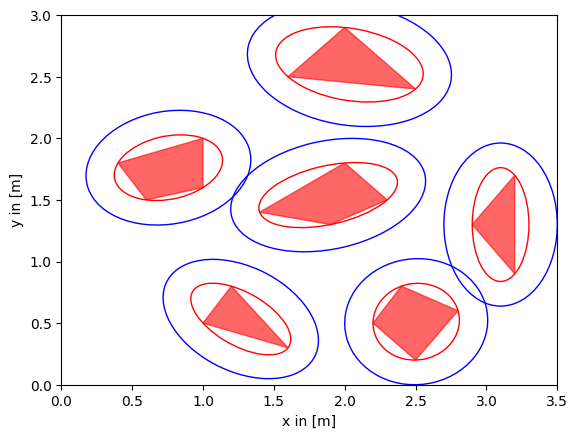

In [ ]:
# radius robot
r = 0.2

# init empty lists


# PUT YOUR CODE HERE
def enlargement_of_ellipsoid(obstacle_ellipsoids, r):
    # Eigendecomposition of A
    enlarged_ellipses = []
    for (A, c) in obstacle_ellipsoids:
        # Eigendecomposition of A
        Lambda, R = np.linalg.eig(A)
        width = 2 * (sqrt(1 / Lambda[0]) + r)
        height = 2 *(sqrt(1 / Lambda[1]) + r)
        Lambda[0] = 1 / (width/2)**2
        Lambda[1] = 1 / (height/2)**2
        A_new = np.dot(np.dot(R, np.diag(Lambda)), np.linalg.inv(R))
        enlarged_ellipses.append((A_new, c))
    return enlarged_ellipses

enlarged_ellipses = enlargement_of_ellipsoid(obstacle_ellipsoids, r)


# generate plot objects
enlarged_ellipses_patches = []
for (A, c) in enlarged_ellipses:
  Lambda, R = np.linalg.eig(A)
  width = 2 * sqrt(1 / Lambda[0])
  height = 2 * sqrt(1 / Lambda[1])
  angle = atan2(R[1, 0], R[0, 0]) * 180 / pi
  ellipse = Ellipse(c, width, height, angle=angle, facecolor='none')
  ellipse.set_edgecolor([0, 0, 1])
  enlarged_ellipses_patches.append(ellipse)

fig, ax = plt.subplots()

for e_ in enlarged_ellipses_patches:
    ax.add_artist(copy(e_))

for e in ellipses:
    ax.add_artist(copy(e))

ax.add_collection(deepcopy(p_col))
ax.set_xlim([0,3.5])
ax.set_ylim([0,3])
ax.set_xlabel("x in [m]")
ax.set_ylabel("y in [m]")
plt.show()


Now that we have obtained a smooth expression for collision checking with the obstacles based on just the robot position $\mathbf{x}_t$, we can formulate our motion planning problem in `casadi`. Implement the optimization problem for a quadratic cost function of the form
\begin{align}
J\left(\mathbf{x}_t, \mathbf{u}_t\right) = \left(\mathbf{x}_t - \mathbf{x}_G\right)^T \mathbf{Q} \left(\mathbf{x}_t - \mathbf{x}_G\right) + \mathbf{u}^T \mathbf{R} \mathbf{u}_t  
\end{align}
for $\mathbf{Q} = \mathbf{I}_{3 \times 3}$ and $\mathbf{R} = \mathrm{diag}([2, 2])$. The dynamics model is given by
$$
\begin{bmatrix}
    x_{k+1}\\
    y_{k+1}\\
    \theta_{k+1}
    \end{bmatrix} = \begin{bmatrix}
    x_k - u_1 \Delta t sin(\theta)\\
    y_k + u_1 \Delta t cos(\theta)\\
     \theta _k + u_2 \Delta t
\end{bmatrix}.
$$
and the feasible control set is defined as $\mathcal{U} = \left\{[u_1, u_2]^T \in \mathbb{R}^2 \mid 0 \leq u_1 \leq 1\right\}$. Hint: Remember to use `casadi` functions for the trigonometric functions.

In [ ]:
import casadi as ca

opti = ca.Opti()

# Trajectory length
N = 100
dt = 0.1

# PUT YOUR CODE HERE
# Decision variables
x = opti.variable(3, N) # state vector [x, y, theta]
u = opti.variable(2, N) # Control vector [u1 u2]

# Objective function
total_cost = sum([(x[0, i] - xG[0])**2 + (x[1, i] - xG[1])**2 + (x[2, i] - xG[2])**2 + 2*u[0, i]**2 + 2*u[1, i]**2 for i in range(N-1)])
opti.minimize(total_cost)

# Dynamoc model constraints

x_next = ca.vertcat(
    x[0] - u[0] * dt * ca.sin(x[2]),
    x[1] + u[0] * dt * ca.cos(x[2]),
    x[2] + u[1] * dt
)


# Dynamics constraints
for k in range(N-1):
    next_state = ca.substitute(x_next, x, x[:, k])
    next_state = ca.substitute(next_state, u, u[:, k])
    opti.subject_to(x[:, k+1] == next_state)

# Initial and final state constraints
opti.subject_to(x[:, 0] == x0)
opti.subject_to(x[:, N-1] == xG)

# Control constraints
for k in range(N-1):
    opti.subject_to(u[0, k] >= 0.)
    opti.subject_to(u[0, k] <= 1)

# obsticle constraints
for j in range(N-1):
  for (A, c) in enlarged_ellipses:
    # MVEE algorithm
    opti.subject_to(A[0, 0]* (x[0, j] - c[0])**2 + (A[0, 1] + A[1, 0]) * (x[0, j] - c[0]) * (x[1, j] - c[1]) + A[1, 1] * (x[1, j] - c[1])**2 > 1)


# Intialize optimization with linear intepolation
for v in range(N-1):
  opti.set_initial(x[0, v], x0[0] + v/(N-1)*(xG[0] - x0[0]))
  opti.set_initial(x[1, v], x0[1] + v/(N-1)*(xG[1] - x0[1]))
  opti.set_initial(x[2, v], x0[2] + v/(N-1)*(xG[2] - x0[2]))
  opti.set_initial(u[0, v], 0)
  opti.set_initial(u[1, v], 0)

# Solver setup and solve
opti.solver('ipopt')
sol = opti.solve()

# Results
traj = sol.value(x)
u_traj = sol.value(u)



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1095
Number of nonzeros in inequality constraint Jacobian.:     1386
Number of nonzeros in Lagrangian Hessian.............:      693

Total number of variables............................:      500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      303
Total number of inequality c

After solving the optimization problem, we can visualize our results!

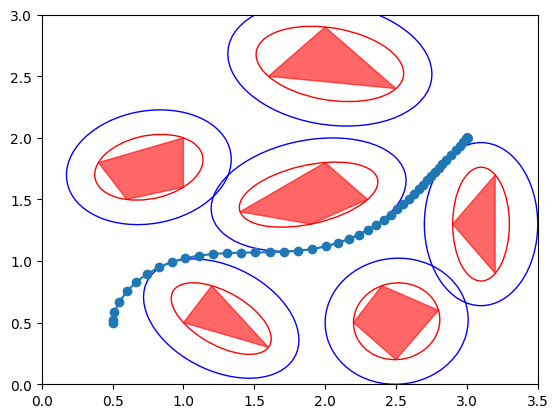

In [ ]:
import matplotlib.pyplot as plt



fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(traj[0, :], traj[1, :], marker='o')

for e_ in enlarged_ellipses_patches:
    ax1.add_artist(copy(e_))

for e in ellipses:
    ax1.add_artist(copy(e))


ax1.add_collection(copy(p_col))
ax1.set_xlim([0,3.5])
ax1.set_ylim([0,3])
plt.show()

ax1.set_xlabel("x in [m]")
ax1.set_ylabel("y in [m]")


plt.show()


**Aaand also animate!**

In [ ]:
%matplotlib inline
%matplotlib notebook
%matplotlib notebook
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from math import *

def animation_func(i, data):
    x = data[0]
    y = data[1]
    theta = data[2]
    # Drone dimension: width l
    l = 0.3
    p1 = [x[i] + cos(theta[i]) * l/2, y[i] + sin(theta[i]) * l/2]
    p2 = [x[i] - cos(theta[i]) * l/2, y[i] - sin(theta[i]) * l/2]
    line1.set_xdata([p1[0], p2[0]])
    line1.set_ydata([p1[1], p2[1]])
    # Plot trajectory
    pt, = ax.plot([x[i]], [y[i]], "g.", markersize=1)

    ax.add_collection(deepcopy(p_col))

    return line1, pt

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.set_xlim([0., 4.])
ax.set_ylim([0., 4.])
line1, = ax.plot([x0[0]-0.15, x0[0] + 0.15], [0., 0.], 'ko-', lw=1.5, markersize=5)

x_data = traj[0, :]
y_data = traj[1, :]
theta_data = traj[2, :]
animation = FuncAnimation(fig, animation_func, fargs=((x_data, y_data, theta_data),),
                          frames=N, interval=50, blit=True)
# plt.show()
HTML(animation.to_html5_video())

<IPython.core.display.Javascript object>

## Optimization-based Motion Planning: Dynamic Obstacles
Now we will start with moving obstacles! In this case we will assume that the obstacles start in the previous configuration and have a constant velocity in one direction. In the following, create a list of the obstacles at each timestep $t = 0, \dots, N$.

In [ ]:
%matplotlib inline
%matplotlib notebook
%matplotlib notebook

# velocity vectors in xy-plane
velocity_dirs = [[1., 0.], [1., 0.4], [0.4, -1.], [-1, 0.5], [-0.1, 1.], [1., 0.2]]

# velocity magnitudes
velocities = [0.1, 0.15, 0.1, 0.4, 0.3, 0.05]

# list of obstacles at each timestep
timed_obstacles = []
timed_obstacles.append(deepcopy(obstacles))

for k in range(1, N):
    all_obstacles = deepcopy(timed_obstacles[-1])  # Use the last known position of obstacles
    for i, obstacle in enumerate(all_obstacles):
        if isinstance(obstacle, list):  # Check if the obstacle is actually a list of vertices
            all_obstacles[i] = [[vertex[0] + dt * velocities[i] * velocity_dirs[i][0],
                                 vertex[1] + dt * velocities[i] * velocity_dirs[i][1]] for vertex in obstacle]
        else:
            # Handle the case where an obstacle might not be a list
            print(f"Warning: Obstacle at index {i} is not a list, skipping.")
    timed_obstacles.append(all_obstacles)


def animation_obstacles(i):
    for j, p in enumerate(moving_patches):
        new_pos = np.append(timed_obstacles[i][j], [timed_obstacles[i][j][0]], axis=0)
        p.set_xy(new_pos)

    return moving_patches,


fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.set_xlim([0., 4.])
ax.set_ylim([0., 4.])

moving_patches = []
for p in patches:
  moving_patches.append(Polygon(p.get_xy()))

for p in moving_patches:
    p.set_color([1, 0, 0])
    ax.add_patch(p)

animation = FuncAnimation(fig, animation_obstacles, frames=N, interval=50, blit=True)

HTML(animation.to_html5_video())

<IPython.core.display.Javascript object>

To use the same constraint formulations as before, we need the ellipsoidal overapproximations over time!

In [ ]:
%matplotlib inline
%matplotlib notebook
%matplotlib notebook


# list of list of ellipses at each time step
timed_ellipses = []

# PUT YOUR CODE HERE

for obs in timed_obstacles:
  over_approx_ellipses = []
  for obs_list in obs:
    A, c = mvee(np.array(obs_list))
    Lambda, R = np.linalg.eig(A)
    width = 2 * (sqrt(1 / Lambda[0]) + r)
    height = 2 *(sqrt(1 / Lambda[1]) + r)
    Lambda[0] = 1 / (width/2)**2
    Lambda[1] = 1 / (height/2)**2
    A = np.dot(np.dot(R, np.diag(Lambda)), np.linalg.inv(R))
    over_approx_ellipses.append((A, c))
  timed_ellipses.append(over_approx_ellipses)


# Animations
def animation_ellipses(i):
    for j, p in enumerate(moving_patches):
        new_pos = np.append(timed_obstacles[i][j], [timed_obstacles[i][j][0]], axis=0)
        p.set_xy(new_pos)

    for j, e in enumerate(moving_ellipses):
        e.set_center(timed_ellipses[i][j][1])

    return moving_patches, moving_ellipses,


fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.set_xlim([0., 4.])
ax.set_ylim([0., 4.])

# moving_patches = copy(patches)
moving_patches = []
for p in patches:
  moving_patches.append(Polygon(p.get_xy()))
# moving_ellipses = copy(enlarged_ellipses_patches
moving_ellipses = []
for e in enlarged_ellipses_patches:
  moving_ellipses.append(Ellipse(e.get_center(), e.width, e.height, angle=e.angle, facecolor='none'))

for p in moving_patches:
    p.set_color([1, 0, 0])
    ax.add_patch(p)

for e in moving_ellipses:
    e.set_edgecolor([0, 0, 1])
    ax.add_artist(e)

animation = FuncAnimation(fig, animation_ellipses, frames=N, interval=50, blit=True)

# plt.show()
HTML(animation.to_html5_video())

<IPython.core.display.Javascript object>

**We're almost there!** Formulate the optimization problem in the case of moving obstacles!

In [ ]:

# Trajectory length
N = 100
dt = 0.1

# PUT YOUR CODE HERE
# Decision variables
x = opti.variable(3, N) # state vector [x, y, theta]
u = opti.variable(2, N) # Control vector [u1 u2]

# Objective function
total_cost = sum([(x[0, i] - xG[0])**2 + (x[1, i] - xG[1])**2 + (x[2, i] - xG[2])**2 + 2*u[0, i]**2 + 2*u[1, i]**2 for i in range(N-1)])
opti.minimize(total_cost)

# Dynamoc model constraints

x_next = ca.vertcat(
    x[0] - u[0] * dt * ca.sin(x[2]),
    x[1] + u[0] * dt * ca.cos(x[2]),
    x[2] + u[1] * dt
)


# Dynamics constraints
for k in range(N-1):
    next_state = ca.substitute(x_next, x, x[:, k])
    next_state = ca.substitute(next_state, u, u[:, k])
    opti.subject_to(x[:, k+1] == next_state)

# Initial and final state constraints
opti.subject_to(x[:, 0] == x0)
opti.subject_to(x[:, N-1] == xG)

# Control constraints
for k in range(N-1):
    opti.subject_to(u[0, k] >= 0)
    opti.subject_to(u[0, k] <= 1)

# Obstacle constraints: (x−c)^T A (x−c) > 1 for all objects
for j in range(N-1):
  for (A, c) in timed_ellipses[j]:
    # MVEE algorithm
    opti.subject_to(A[0, 0]* (x[0, j] - c[0])**2 + (A[0, 1] + A[1, 0]) * (x[0, j] - c[0]) * (x[1, j] - c[1]) + A[1, 1] * (x[1, j] - c[1])**2 > 1)


# Solver setup and solve
opti.solver('ipopt')
sol = opti.solve()

# Results
traj = sol.value(x)
u_traj = sol.value(u)



This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     2190
Number of nonzeros in inequality constraint Jacobian.:     2772
Number of nonzeros in Lagrangian Hessian.............:     1188

Total number of variables............................:     1000
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      606
Total number of inequality constraints...............:     1584
        inequality constraints with only lower bounds:     1386
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      198

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.2870000e+03 3.00e+00 6.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

Visualization of the obtained trajectory.

In [ ]:
%matplotlib inline
%matplotlib notebook
%matplotlib notebook
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from math import *

def animation_func(i, data):
    x = data[0]
    y = data[1]
    theta = data[2]
    # Drone dimension: width l
    l = 0.3
    p1 = [x[i] + cos(theta[i]) * l/2, y[i] + sin(theta[i]) * l/2]
    p2 = [x[i] - cos(theta[i]) * l/2, y[i] - sin(theta[i]) * l/2]
    line1.set_xdata([p1[0], p2[0]])
    line1.set_ydata([p1[1], p2[1]])
    # Plot trajectory
    pt, = ax.plot([x[i]], [y[i]], "g.", markersize=1)

    for j, p in enumerate(moving_patches):
        new_pos = np.append(timed_obstacles[i][j], [timed_obstacles[i][j][0]], axis=0)
        p.set_xy(new_pos)

    return line1, pt, moving_patches,

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.set_xlim([0., 4.])
ax.set_ylim([0., 4.])
line1, = ax.plot([x0[0]-0.15, x0[0] + 0.15], [0., 0.], 'ko-', lw=1.5, markersize=5)

moving_patches = []
for p in patches:
  moving_patches.append(Polygon(p.get_xy()))

for p in moving_patches:
    p.set_color([1, 0, 0])
    ax.add_patch(p)

x_data = traj[0, :]
y_data = traj[1, :]
theta_data = traj[2, :]
animation = FuncAnimation(fig, animation_func, fargs=((x_data, y_data, theta_data),),
                          frames=N, interval=50, blit=True)
# plt.show()
HTML(animation.to_html5_video())

<IPython.core.display.Javascript object>

# What if we have uncertainties such as initial positions? Feedback Motion Primitives!

In the previous setting, we have found an open loop trajectory for our robot. When applying this to a real robot it will most likely fail if we do not use a tracking controller to account for small deviations from the reference trajectory.

However, if we deviate from the reference trajectory, we are not ensured anymore that the robot will move on a collision-free trajectory. So in safety-critical applications, it is important to consider safety on different levels of the planning hierarchy (motion planning, control) in order to make our robots more robust.

In this section, we will look into Feedback motion primitives to ensure safety even if the reference trajectory cannot be tracked accurately.

In [ ]:
!pip install pypolycontain
import pypolycontain as pp

# shapely is used for collision checking. It might not necessarily refer to zonotopes
# but we can always transfer
# https://shapely.readthedocs.io/en/stable/manual.html
from shapely.geometry import box, MultiPoint
from shapely.geometry import Polygon as Poly

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from copy import deepcopy, copy
from math import *

import numpy as np
# for the animations
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

We first use our well-known dynamics model to be able to simulate our system.

In [ ]:
def dynamics(x, u):
    """
    Inputs: current state of the system x, control input u
    Output: derivative of the state vector
    """
    dx = np.array([- u[:, 0] * np.sin(x[:, 2]), u[:, 0] * np.cos(x[:, 2]), u[:, 1]]).T
    return dx


def discrete_dynamics(x, u):
    """
    Inputs: current state of the system x, control input u
    Output: next state vector
    """
    dt = 0.1
    x_next = x + dt * dynamics(x, u)
    return x_next

Next, we will define our set of initial states as well as our input set. From this we will construct a **single** feedback motion primitive. Later, we will generalize these results to obtain multiple primitives that can be used for planning. In the following, define two zonotopes $X0$ and $U$ for the previously mentioned sets. The initial set is centered at the origin with orientation zero and has a total width of $0.1$ in each state direction. The input set is defined as $U = \left\{[u_1, u_2]^T \in \mathbb{R}^2 \mid 0.2 \leq u_1 \leq 0.3, 0.5 \leq u_2 \leq 1\right\}$.

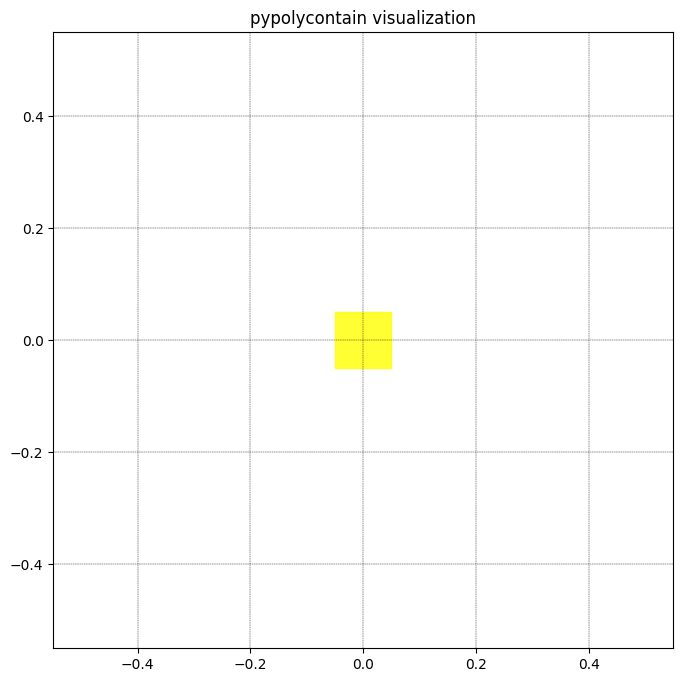

In [ ]:
%matplotlib inline

nx = 3
nu = 2
# Intial State set
center_point = np.array([0, 0, 0])
generator_point = np.array([[0.05, 0, 0], [0, 0.05, 0], [0, 0, 0.05]])

X0 = pp.zonotope(x=center_point, G=generator_point, color = 'yellow')

center_u = np.array([0.25, 0.75])
generator_u = np.array([[0.05, 0], [0, 0.25]])

U = pp.zonotope(x=center_u, G=generator_u, color = 'blue')

# visualize intial set
fig, ax = plt.subplots()

try:
  pp.visualize([pp.zonotope(x = X0.x[0:2], G = X0.G[0:2, :], color = 'yellow')], fig=fig, ax=ax)
  pp.visualize([pp.zonotope(x = X0.x[0:2], G = X0.G[0:2, :], color = 'yellow')], fig=fig, ax=ax)
except:
  pass
plt.show()

Next, we would like to be able to sample trajectories from our system given the initial states and the input sets. For that purpose, we need a function that allows us to sample a point from a zonotope.

In [ ]:
def sample_zonotope(zt):
  """
  Input: pp zonotope
  Output: uniformly sampled point inside zonotope
  """
  # nr of generator gives us the dimension of the sampling space
  c = zt.x
  G = zt.G
  dim = len(c)
  z = np.random.uniform(-1, 1, (dim, 1))
  z = np.dot(G, z).T + c
  return z.flatten()



We will now sample a bunch of initial states and input trajectories of length $N_s = 20$ to fit a linear model to the multi-step solution of our dynamical system. Fill the matrices!

In [ ]:
# number of timesteps for feedback motion primitive
N_s = 20

# sampled trajectories
n_samples = 10000

state_traces = np.zeros((n_samples, nx, N_s))
input_traces = np.zeros((n_samples, nu, N_s - 1))

#PUT YOUR CODE HERE

# Sample n_samples trajectories for input and the intial state trace
for i in range(n_samples):
    state_traces[i, :, 0] = sample_zonotope(X0)
    for j in range(N_s - 1):
        input_traces[i, :, j] = sample_zonotope(U)
#propagate the state trace using input trace abd the dynamic
for input_i  in range(N_s - 1):
    state_traces[:, :, input_i + 1] = discrete_dynamics(state_traces[:, :, input_i], input_traces[:, :, input_i])


Next, we're gonna fit a linear model for the transition from initial state $x_0$ to the state after $x_{T}$ after $N_s=20$ timesteps. Note, that this is not a linear model relating the state at the next time step to the current one, but predicting the state after $T$ timesteps, i.e.

$$
\mathbf{x}_{t+N_s} = \mathbf{A} \mathbf{x}_t + \mathbf{B} \begin{bmatrix}
\mathbf{u}_t\\
\mathbf{u}_{t+1}\\
\vdots\\
\mathbf{u}_{t+N_s - 1}
\end{bmatrix} + \mathbf{c}
$$

where $\mathbf{A} \in \mathbb{R}^{n_x \times n_x}, \mathbf{B} \in \mathbb{R}^{n_x \times (N_s-1) n_u}$ and $\mathbf{c}\in \mathbb{R}^{n_x}$. To find this model, we will make use of the LinearRegression function in `sklearn`. Since this is mainly annoying formatting, the function is provided in the following. To ensure that we are not overfitting to the data, we seperate the input and outputs into a training and test set. At the end, an approximate linearization error is calculated based on the error on a test set.

In [ ]:
from sklearn.linear_model import LinearRegression

# Seperate data into training and test set: 2/3 training 1/3 test
ind = int(np.floor((2/3) * n_samples))

# training set
initial_states_train = state_traces[:ind, :, 0]
inputs_train = np.moveaxis(input_traces[:ind, :, :], 1, -1).reshape((ind, -1))
training_input = np.concatenate((initial_states_train, inputs_train), axis=1)
training_output = state_traces[:ind, :, -1]
model = LinearRegression().fit(training_input, training_output)

# obtain model
A = model.coef_[:, :nx]
B = model.coef_[:, nx:]
c = model.intercept_


# test set
initial_states_test = state_traces[ind:, :, 0]
inputs_test = np.moveaxis(input_traces[ind:, :, :], 1, -1).reshape((n_samples - ind, -1))
test_input = np.concatenate((initial_states_test, inputs_test), axis=1)
test_output = state_traces[ind:, :, -1]

# Error on training set
prediction = model.predict(training_input)
err_training = abs(prediction - training_output)
max_error_training = np.max(err_training, axis=0)
print("Max error on training data: " + str(max_error_training))

# Error on test set
prediction = model.predict(test_input)
err_test = abs(prediction - test_output)
max_error_test = np.max(err_test, axis=0)
print("Max error on test data: " + str(max_error_test))

# overapproximate linearization error
linearization_error = max_error_test * 1.5



Max error on training data: [5.27464204e-03 5.35157596e-03 8.21565038e-15]
Max error on test data: [5.14401952e-03 4.97069912e-03 8.21565038e-15]


Now, we've fitted a linear model to the transition which allows us to calculate reachable sets! Overall, the reachable set of our system after $T$ steps can be obtained as

$$
\begin{align}
\mathcal{R}_T &= \left\{\mathbf{A} \mathbf{x}_0 + \mathbf{B} \mathbf{u}_{0:(N_s-1)} + c \mid \mathbf{x}_0 \in X0, \mathbf{u}_i \in U,  \forall i = 0,\dots, N_s-1\right\}\\
&= \left\{\mathbf{A} \mathbf{x}_0 + c \mid \mathbf{x}_0 \in X0\right\} \bigoplus \left\{\mathbf{B} \mathbf{u}_{0:(N_s-1)}\mid \mathbf{u}_i \in U,  \forall i = 0,\dots, N_s-1\right\}\\
&:= \mathcal{R}_x \bigoplus \mathcal{R}_u
\end{align}
$$

Calculate these zonotopes!

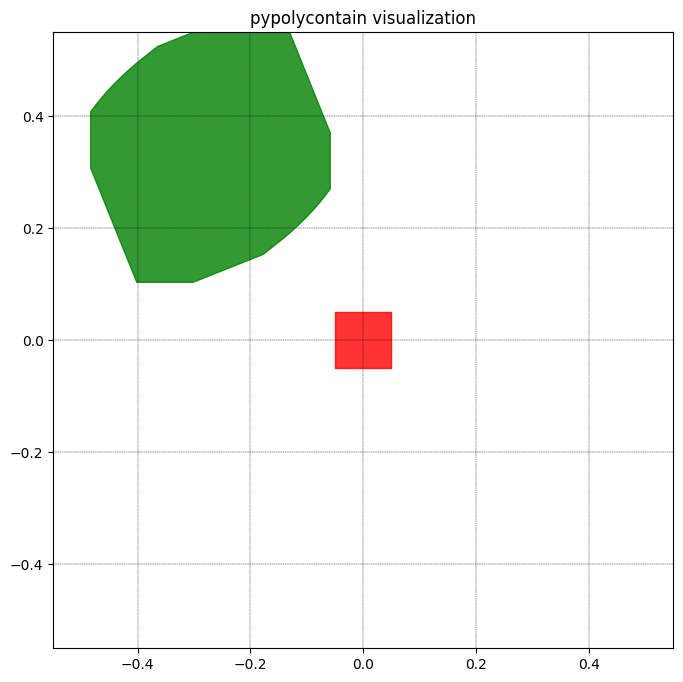

In [ ]:
from scipy.linalg import block_diag
# Reachable sets Rx and Ru as pp zonotopes
# Input zonotope
#center_u = np.array([0.25, 0.75])
#generator_u = np.array([[0.05, 0], [0, 0.25]])

# Stack control zonotope
center_u_stack = np.tile(center_u, N_s - 1)  # (nu * (N_s - 1),)
generator_u_stack = block_diag(*[generator_u] * (N_s - 1))  # (nu * (N_s - 1), nu * (N_s - 1))

# Compute reachable sets
Rx = pp.zonotope(x=A @ X0.x + c, G=A @ X0.G, color='orange')
Ru = pp.zonotope(x=B @ center_u_stack, G=B @ generator_u_stack, color='red')
# Minkowski sum of sets
R = pp.zonotope(x=Rx.x + Ru.x, G=np.hstack((Rx.G, Ru.G)), color='green')

# visualization of Reachable set (projected to xy-plane)
fig, ax = plt.subplots()
# 2D zonotope
Ru_2d = pp.zonotope(x=Ru.x[0:2], G=Ru.G[0:2,:])
R2d = pp.zonotope(x=R.x[0:2],G=R.G[0:2,:])
try:
  pp.visualize([pp.operations.pca_order_reduction(R2d, 6)], fig=fig, ax=ax)
except:
  pass
try:
  pp.visualize([pp.zonotope(x=X0.x[0:2], G=X0.G[0:2, :], color='red')], fig=fig, ax=ax)
except:
  pass
plt.show()

In [ ]:
# Linearization Error bounds as zonotope
Rw = pp.zonotope(x=np.zeros(3), G=np.diag(linearization_error))

Here, we will also visualize some of the sampled trajectories. Why is the reachable set much larger than the actual sampled final states? In case you want to find out, sample some trajectories where you just take the extreme values of $\mathbf{u}$ over the entire trajectory and visualize them!

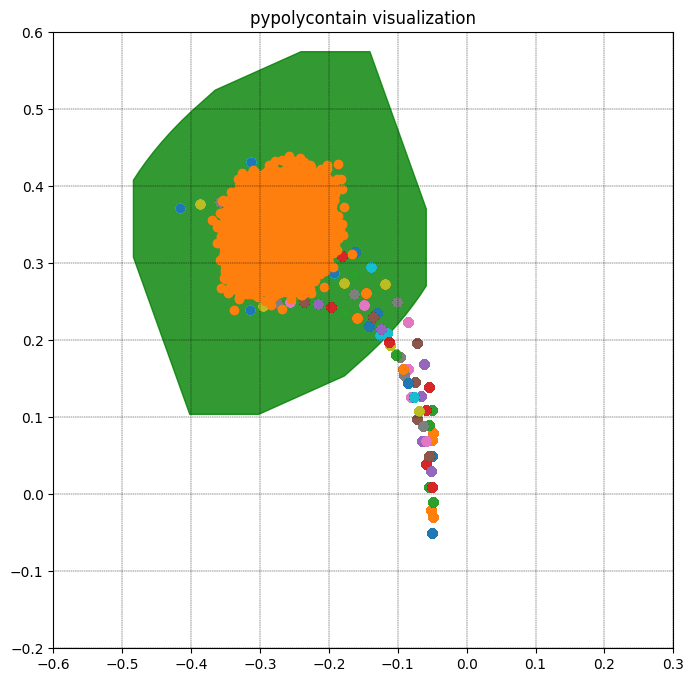

In [ ]:
fig, ax = plt.subplots()
try:
  pp.visualize([pp.operations.pca_order_reduction(R2d, 6)], fig=fig, ax=ax)
except:
  pass

CORNER_CASE = True
extreme_input_points = pp.zonotope_to_V(U)

extreme_state_points = pp.zonotope_to_V(X0)

extreme_samples = extreme_input_points.shape[0]

input_traces_extreme = np.zeros((extreme_input_points.shape[0], nu, N_s - 1))
state_traces_extreme = np.zeros((extreme_samples, nx, N_s))

for j in range(extreme_samples):
    state_traces_extreme[j, :, 0] = extreme_state_points[j, :]

for k in range(N_s - 1):
    input_traces_extreme[:, :, k] = extreme_input_points
    state_traces_extreme[:, :, k + 1] = discrete_dynamics(state_traces_extreme[:, :, k], input_traces_extreme[:, :, k])



idx = np.random.randint(n_samples, size=10000)

# Optional: sample corner case scenarios and visualize them
if CORNER_CASE:
    idx = np.random.randint(extreme_samples, size=10000)
    for i in range(0, N_s):
        plt.scatter(state_traces_extreme[idx, 0, i], state_traces_extreme[idx, 1, i])
    plt.scatter(state_traces_extreme[:, 0, -1], state_traces_extreme[:, 1, -1])

else:
  for i in range(0, N_s):
    plt.scatter(state_traces[idx, 0, i], state_traces[idx, 1, i])
plt.scatter(state_traces[:, 0, -1], state_traces[:, 1, -1])
ax.set_xlim([-0.6, 0.3])
ax.set_ylim([-0.2, 0.6])
plt.show()

Now, the goal is to find a control policy $\mathbf{u}_{0:(N_s-1)} = -\mathbf{K} \mathbf{x}_0$ s.t. the reachable set is shrunk to the linearization error meaning that $\mathcal{R}_u$ cancels out $\mathcal{R}_x$, i.e. $\mathbf{A} - \mathbf{BK} = \mathbf{0}$. Note, that this is a mapping from the initial state to a sequence of control inputs, thus $\mathbf{K} \in \mathbb{R}^{n_x \times n_u (N_s - 1)}$. However, this problem cannot be uniquely solved since the $\mathbf{B}$ matrix is not invertible. One approach to solve for a feedback matrix is to use the pseudoinverse $\mathbf{K} = \mathbf{B}^\dagger \mathbf{A}$ which, however, does not ensure that our inputs $\mathbf{u}_{0:(N_s-1)} = -\mathbf{K} \mathbf{x}_0 \in U$ are inside the feasible control set. An alternative is to formulate this as an optimization problem in which we would like to minimize the control effort (magnitude of $\mathbf{K}$) subject to reachable set cancellation and input constraints:

$$
\begin{aligned}
	\min_{K = [K_{ij}]} \quad &[K_{11}, K_{12}, \dots, K_{nm}]^T Q [K_{11}, K_{12}, \dots, K_{nm}]\\
	\textrm{s.t.  } \quad  &A - BK= 0\\
  \quad &-Kv \in U, \forall v \in \mathrm{vertices}(X0)
    \end{aligned}.
$$
Due to linearity, it is sufficient to enforce input constraints at the vertices of the initial state set!

In the last tutorial, we have used pythons `CVXOPT` library to efficiently solve a quadratic program for control synthesis. Since the optimization problem is also a QP, we can make use of the same library. Have a look at $\href{https://cvxopt.org/examples/tutorial/qp.html}{this} $ example on formulating a QP in cvxopt.

Tips from Metti:
The feeback controller thatc is designed is used to stabilize the nomimnal trajectory wich corresponds to the input u0:(N-1) = u_ff - Kx0 where the feedforward term is the zonotope center i.e. u_ff = Ux. So you fomulate the input ssaturation constraintants, the feasible input set for -Kx0 is defined to the zonotope center.
We got DIM K = 3 x 38,
$\mathbf{A} \in \mathbb{R}^{n_x \times n_x}, \mathbf{B} \in \mathbb{R}^{n_x \times (N_s-1) n_u}$ and $\mathbf{c}\in \mathbb{R}^{n_x}$.

General Form of QP :

![image-2.png](attachment:image-2.png)

In [ ]:
# Some imports for the QP formulation
from cvxopt import matrix, solvers

# set up QP

# number of decision variables
Kx = nx
Ky =  (nu * (N_s-1))

# as above mentioned for K
K = np.zeros((Ky, Kx))
# cost function
Q = matrix(2 * np.identity(Kx*Ky), tc = 'd')
p = matrix(np.zeros(Kx*Ky), tc = 'd')

# Equality constraints
A_eq = matrix(np.kron(B, np.identity(Kx)), tc = 'd')  # Handling the LHS of the equality constraints
b_eq = matrix(A.flatten(), tc = 'd') # Handling the RHS of the constraints

# Inequality constraints
G_ineq_empty = np.empty((0, Ky*Kx))
vertices_X0 = pp.conversions.zonotope_to_V(X0)

# We start to itrate from all X0 vertices
for initial_vertex in vertices_X0:

  # We need to map state to control inputs for teh vertex by using Kronecker
  kron_matrix = -np.kron(np.identity(Ky), np.transpose(initial_vertex))

  # here we handle the upper and lower band for the current vertex
  G_ineq_empty = np.vstack((G_ineq_empty, kron_matrix, -kron_matrix))
# The input is defined relative to zonotope center
h_ineq =  matrix(
    np.tile(
        np.concatenate(
            (np.tile([0.05, 0.25], N_s - 1), np.tile([-(-0.05), -(-0.25)], N_s - 1))
        ),len(vertices_X0),),tc="d",)


# recall G_ineq_empty to q_ineq in order to cvxopt matrix
G_ineq = matrix(G_ineq_empty, tc = 'd')

solvers.options['show_progress'] = True
sol = solvers.qp(Q, p, G_ineq, h_ineq, A_eq, b_eq)
K = np.array(sol['x']).reshape(Ky, Kx)

print("Test: A-BK = " + str(A - B @ K))

     pcost       dcost       gap    pres   dres
 0:  4.4168e+01 -5.5566e+01  9e+02  6e+00  3e-15
 1:  4.4169e+01 -2.7870e+01  1e+02  7e-01  2e-15
 2:  4.6022e+01 -1.1437e+01  1e+02  5e-01  3e-15
 3:  5.2065e+01  1.9813e+01  1e+02  4e-01  1e-14
 4:  7.5238e+01  6.4411e+01  9e+01  2e-01  2e-14
 5:  9.4258e+01  8.8577e+01  6e+01  1e-01  2e-14
 6:  1.0846e+02  1.0152e+02  5e+01  7e-02  2e-14
 7:  1.2018e+02  1.1367e+02  3e+01  3e-02  3e-14
 8:  1.2869e+02  1.2163e+02  2e+01  1e-02  3e-14
 9:  1.3432e+02  1.2902e+02  7e+00  2e-03  5e-14
10:  1.3451e+02  1.3402e+02  6e-01  1e-04  7e-14
11:  1.3450e+02  1.3445e+02  6e-02  1e-05  7e-13
12:  1.3449e+02  1.3449e+02  2e-03  3e-07  3e-12
13:  1.3449e+02  1.3449e+02  2e-05  3e-09  7e-12
Optimal solution found.
Test: A-BK = [[ 2.22044605e-16  4.75151602e-17  0.00000000e+00]
 [ 6.51063405e-17  2.22044605e-16  0.00000000e+00]
 [-3.16316384e-16 -6.10173127e-16  7.77156117e-16]]


Let's see if it worked! Use the initial state set X0 and forward propagate the closed loop dynamics!

(-0.1, 1.0)

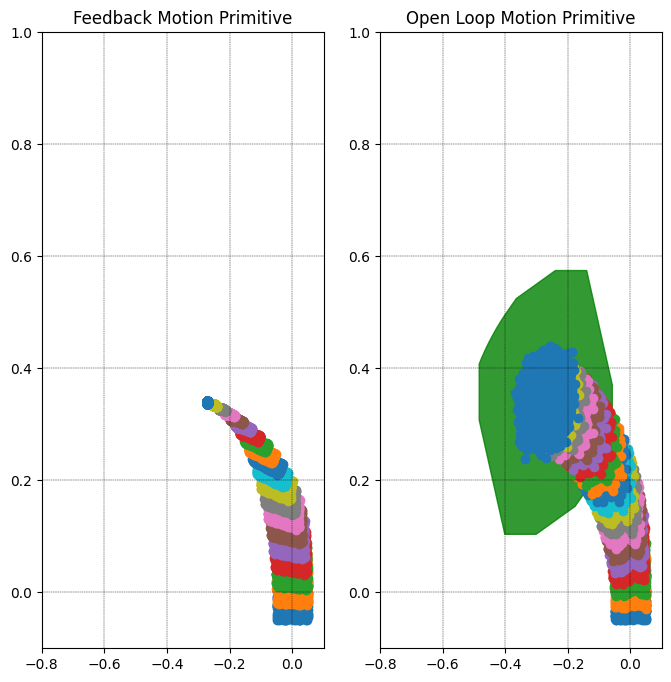

In [ ]:
# state trajectories for controlled system
feedback_state_traces = np.zeros((n_samples, nx, N_s))

# PUT YOUR CODE HERE
# we samples n_samples trajectories for the input
for i in range(n_samples):
    feedback_state_traces[i, :, 0] = sample_zonotope(X0)
# U.x is control input sppile across all samples and time steps
feed_forward = np.tile(U.x, (n_samples, 1))
U_feedback = np.dot(-feedback_state_traces[:,:,0], np.transpose(K))
# propagate the state trace using input trace andd the dynamic
for input_i  in range(N_s - 1):
    feedback_state_traces[:, :, input_i + 1] = discrete_dynamics(feedback_state_traces[:, :, input_i], U_feedback[:, 2*input_i:2*(input_i+1)] + feed_forward )
# visualizations
fig = plt.figure()
ax = fig.add_subplot(121)

# Visualize feedback samples
idx = np.random.randint(n_samples, size=1000)
try:
  pp.visualize([pp.zonotope(x=Rw.x[0:2] + R.x[0:2], G=Rw.G[0:2, :])], fig=fig, ax=ax, title="Feedback Motion Primitive")
except:
  pass
for i in range(0, N_s):
    plt.scatter(feedback_state_traces[idx, 0, i], feedback_state_traces[idx, 1, i])
plt.scatter(feedback_state_traces[:, 0, -1], feedback_state_traces[:, 1, -1])
ax.set_xlim([-0.8, 0.1])
ax.set_ylim([-0.1, 1.])

ax1 = fig.add_subplot(122)

# visualize open loop samples
idx = np.random.randint(n_samples, size=1000)
try:
  pp.visualize([pp.operations.pca_order_reduction(R2d, 6)], fig=fig, ax=ax1, title="Open Loop Motion Primitive")
except:
  pass
for i in range(0, N_s):
    plt.scatter(state_traces[idx, 0, i], state_traces[idx, 1, i])
plt.scatter(state_traces[:, 0, -1], state_traces[:, 1, -1])
ax1.set_xlim([-0.8, 0.1])
ax1.set_ylim([-0.1, 1.])

**We are almost there!** We now have a single feedback motion primitive and we have canceled out the two reachable sets $\mathcal{R}_x$ and $\mathcal{R}_u$ and are only left with the linearization error. For our future analysis we are not only interested in where the robot will end up but also in all possible positions that the robot might reach when using the obtained controller. Thus, we are interested in the reachable tube of the feedback motion primitive! Since we've done a discrete analysis, we have to be careful as we are not entirely sure what happens in between discrete time steps... Next, use the samples from the closed loop system to obtain polygons that contain all the samples at each discrete time step $t_i$. Then, use some method to account for the continuous-time evolution in between time steps.

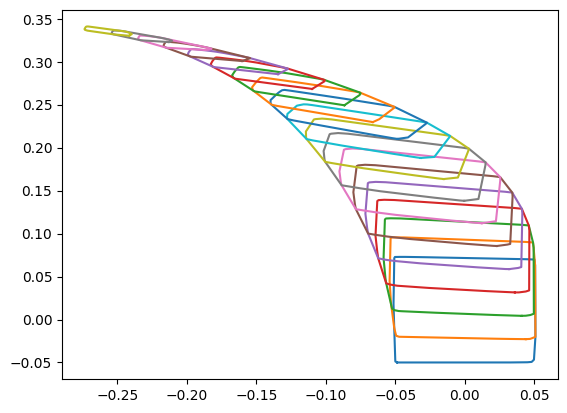

In [ ]:
# reachable tube (list of polygons, I use shapely polygons since we will use
# these polygons for collision checking but feel free to use another representation)
reachable_tube = []
discrete_reachable_tube = []


# PUT YOUR CODE HERE
for time_step in range(N_s):
  state_points = feedback_state_traces[:, :2, time_step]
  discrete_reachable_tube.append(MultiPoint(state_points).convex_hull)


# we need to convert the discrete reachable tube to continuous-time evolution union of convex hulls
for all_step in range(len(discrete_reachable_tube)-1):
  union_hull = deepcopy(discrete_reachable_tube[all_step].union(discrete_reachable_tube[all_step+1])).convex_hull
  reachable_tube.append(union_hull)
# Visualization (If you don't use shapely polygons you might change the plotting command)
fig = plt.figure()
ax = fig.add_subplot(111)
for p in reachable_tube:
  x, y = p.exterior.coords.xy
  plt.plot(x, y)

Amazing! Recap what we've just obtained: We have

1.   a contracting motion primitive (Final set is smaller than initial set)
2.   a controller $\mathbf{u}_{0:(N_s - 1)} = - \mathbf{K} \mathbf{x}_0$ that maps the initial state to a sequence of control inputs
3. a reachable tube that can be used for collision checking



# Long horizon planning using Feedback Motion Primitives!

Now you know how to generate a single feedback motion primitive given an initial state set $X0$ as well as an input set $U$. The cool thing about feedback motion primitives is that they are a contraction on the state set meaning that they always "shrink" the initial state set. Thus, if we have multiple feedback motion primitives, we can concatenate them since the initial set of a motion primitive is always larger than the end of a motion. This concept is illustrated in the following figure.

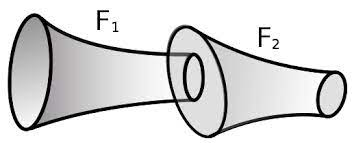

The goal of this section is to come up with an algorithm that connects multiple feedback motion primitives such that we can reach a goal while avoiding collisions with obstacles. We will consider the same static environment as in the first section.

Implement a function that returns N feedback motion primitives starting at the initial set $X0$ with different input sets $U_1, \dots, U_N$ where each input set is defined as $U_i = \left\{[u_1, u_2]^T \in \mathbb{R}^2 \mid 0.2 \leq u_1 \leq 0.3, u_{i, min} \leq u_2 \leq u_{i, max}\right\}$. The input sets should be distributed equidistantly, e.g. $u_{1, min} = u_{min}, u_{N, max} = u_{max}$ and $u_{i, max} = u_{i+1, min}$. Also, represent each feedback motion primitive as a class object of type FBMotion. We later want to use these primitives for collision checking, so it will be useful to also include attributes such as reachable_tube.

In [ ]:
 class FBMotion:
  def __init__(self, X0_set, U_set):
    # Add all the functions you need

  def ...

  def plot(self, ax):
    # plot reachable tube


def generate_feedback_motion_primitives(X, u_min, u_max, N):
  """
  Input: Initial state set X as zonotope, u_min, u_max, number of motion primitives N
  Output: N equidistantly distributed (in input space of u2, keep u1 the same over all primitives) feedback motion primitives
          (list of FBMotion objects)
  """
  motion_primitives = []
  # PUT YOUR CODE HERE

  return motion_primitives

u_min = - 1
u_max = 1
primitives = generate_feedback_motion_primitives(X0, u_min, u_max, 11)

Let's have a look at our motion primitives!

In [ ]:
fig, ax = plt.subplots()
for p in primitives:
  p.plot(ax)

## A* path planning algorithm using motion primitives
In this last step, we will use the obtained N feedback motion primitives for a dynamically feasible A* search. In this section you are free in the way you implement the algorithm, e.g. how to choose costs and heuristics. The goal is to find a sequence of feedback motion primitives that bring the robot from its initial state $x_0$ to the goal state $x_G$ while always staying in the free space $\mathcal{X}\setminus \mathcal{X}_{obs}$.

Here are a couple of hints:


1.   Feedback motion primitives can be shifted and rotated in the configuration space. The final polygon of a motion primitive should always be entirely contained in the first polygon of the next motion primitive when concatenating them.
2.   It is fine if you find a solution that is "close" to the goal state. A solution is accepted if the center of the final polygon $c$ satisfies $\lVert \mathbf{c}_N - \mathbf{x}_G\rVert_2 \leq 0.2$.
3. You can use `shapely.affinity` for transformations and rotations of shapely polygons.
4. Optimality of the solution is not required.
5. The complexity of collision checking can be reduced by first using an overapproximation of the reachable tube. If that over approximation is collision free, you don't need to do complex collision checking.
6. A lot of implementations of the standart A* algorithm in python can be found online ;)
7. A feasible solution could look something like this:

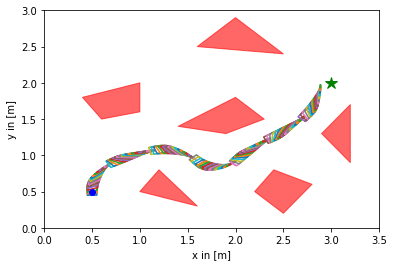



In [ ]:
from shapely import affinity

# feel free to use any other polygon representation
obstacles_shapely = [Polygon(o) for o in obstacles]

# robots initial state
x0 = np.array([0.5,0.5,0])
# goal state
xG = np.array([3., 2, 0])
# collision radius of robot
r = 0.2

# PUT YOUR CODE HERE AND VISUALIZE YOUR RESULTS

## Optional: Test your results and compare

In case you are interested in how the robustness increases using feedback motion primitives, run two simulations of the drone operating in the environment. In this simulation, pick a random initial state from $X0$ and simulate the system with the inputs obtained in the E-level problem as well as the feedback motion primitives. Which one is more robust?